In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, make_scorer

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import seaborn as sns
sns.set(style="ticks")


pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
sns.set(style="ticks")
%matplotlib inline


import seaborn as sns
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)
pd.set_option('max_rows',100)
sns.set_context('poster')

# Methodology

## 1. Loading the Data :
The dataset given in the problem is an highly imbalanced having 0's as the majority class (89%) and 1's as the minority class (11%).

## 2. Feature Selection:
1. Identified features which are important by assessing their correlation with the response: I found that very few features had a strong correlation with the response.
2. Assessed the statistics of the features: All of the features had a very low standard deviation(except 1,2,11,12).
3. Used PCA to reduce the dimension of the data

## 3. Resampling
1. To combat the imabalance in the dataset, I have used resampling techniques. Resampling aims to balance the ratio between the classes of the data. For binary classification, it can either be performed by duplicating samples of minority class(Oversampling) or by eliminating samples of majority class(Undersampling).

2. Resampling techniques used here are: **ROS**(Random Over Sampling), **RUS**(Random Under Sampling), **SMOTE**.

3. Each resampling method is used with two different ratios: 50/50 and 30/70 (minority 1/0 majority).

4. Due to limited time only two ratio sizes were used for training.

5. Resampling of the training data thus resulted in 6 training datasets (2 ROS, 2 RUS, 2 SMOTE)

![methodology](images/methodology.PNG)

## 4. Training the Classification Models:
All train datasets (6 in total) were used to train learnable classification methods of three different kinds: Logistic Regression (LR), Decision Tree (DT) and Random Forest (RF). Thus, a total of 18 models were trained.

## 5. Evaluation Metric:

Looking at the percentage of correct classifications (Accuracy) is problematic for class-imbalance data. I have used F1 score and AP(Average Precision) of the Precision-Accuracy plot as my evaluation metric because while dealing with imbalance cases we need a high recall (positive being the minority class) and a low false positive rate(high precision). The F1 score summarizes the overall performance of the classifier overall possible thresholds. It also minimized the negative influence of class imbalance. Thus, an ideal value of F1-score will be 1 and if F1-score is high the True Positives(high recall) will be maximized and False Positives(High Precision) will be minimized, which is desired. 

Therefore, in this model I'm looking for a classifier with the highest possible value of **F1-score** as well as a high value for **Average Precision**.

**Average precision (AP)** summarizes such a plot as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight:

 **$AP =\sum$ (R<sub>n</sub> - R<sub>n-1</sub>) P<sub>n</sub>**
 
 where P<sub>n</sub> and R<sub>n</sub> are the precision and recall at the nth threshold.

# 1.1 Loading the Dataset

In [ ]:
#importing the data
ensemble = pd.read_csv('Data_for_classification.csv')
ensemble.head()

In [3]:
#replacing NaN with zero
ensemble.fillna(0,inplace=True)
ensemble.head()

,ID,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,Target
0,C1,33.05,0.36,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,42.0,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,C4,29.01,0.35,0.0,1.0,0.0,0.0,0.0,4.0,0.0,2.0,45.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,C5,60.10,0.10,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,C6,23.05,0.92,0.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,26.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,C8,44.18,1.18,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,20.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [4]:
#Checking the datatypes of the columns
ensemble.dtypes

ID             object
feature_1     float64
feature_2     float64
feature_3     float64
feature_4     float64
feature_5     float64
feature_6     float64
feature_7     float64
feature_8     float64
feature_9     float64
feature_10    float64
feature_11    float64
feature_12    float64
feature_13    float64
feature_14    float64
feature_15    float64
feature_16    float64
feature_17    float64
feature_18    float64
feature_19    float64
Target        float64
dtype: object

All of the datatypes are either float or int. Thus, no typecasting of any variable is needed

# 1.2 Traget Class distribution Plot

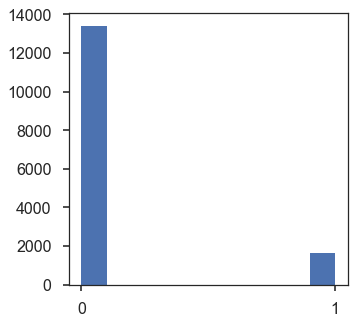

In [5]:
#plotting a histogram of target to see the class distribution#plottin 
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.hist(ensemble['Target'])
ax.set_xticks(range(0,2))
plt.show()

The histogram clearly shows that there is an imbalance between the classes.

In [6]:
#getting the number of zeros and ones in the response Target
ensemble.Target.value_counts()

0.0    13413
1.0     1657
Name: Target, dtype: int64

We see that there are 13413 cases of class 0 and only 1657 cases of class 1.

# 1.3 Feature Selection

In [7]:
ensemble.describe()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,Target
count,15070.000000,15070.000000,15070.000000,15070.000000,15070.000000,15070.000000,15070.000000,15070.000000,15070.0,15070.000000,15070.000000,15070.000000,15070.000000,15070.000000,15070.000000,15070.000000,15070.000000,15070.000000,15070.000000,15070.000000
mean,32.237244,1.013062,0.007565,0.432581,0.431785,0.425813,0.111944,0.470670,0.0,1.420239,25.708096,1.891573,0.132648,0.053550,0.016058,0.006038,0.467618,0.106768,0.085468,0.109954
std,10.124081,1.322976,0.086649,0.495450,0.495341,0.494482,0.315308,0.983524,0.0,0.657460,19.839252,2.864804,0.339205,0.225135,0.125704,0.077475,0.498967,0.308829,0.279586,0.312842
min,15.450000,-0.740000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.230000,0.310000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,29.730000,0.620000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,23.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.330000,1.220000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.0,2.000000,37.000000,3.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,105.780000,18.150000,1.000000,1.000000,1.000000,1.000000,1.000000,23.000000,0.0,5.000000,144.000000,27.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We see that Feature 9 has 0 standard deviation. We will remove this feature because adding any useful information to the model and is only increasing the dimensionality. 

Also, many of the features (except 1,2,11,12) have very low standard deviation.

Low Std makes the variable un-informative for classification purposes. Low variance/std variables may also cause the models to break. Thus, we need to select only those variables which have sufficiently high variance, so that they help us in classification rather than acting as noise

In [8]:
# removing column feature_9 and id because it has zero variance
ensemble=ensemble.drop(['feature_9','ID'],axis=1)
ensemble.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,Target
0,33.05,0.36,0.0,1.0,0.0,0.0,0.0,0.0,2.0,42.0,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,29.01,0.35,0.0,1.0,0.0,0.0,0.0,4.0,2.0,45.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,60.10,0.10,0.0,0.0,0.0,0.0,0.0,1.0,1.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,23.05,0.92,0.0,0.0,0.0,1.0,0.0,1.0,3.0,26.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,44.18,1.18,0.0,1.0,0.0,0.0,0.0,0.0,1.0,20.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


## 1.3.1 Checking the correlation of all features with the response

In [9]:
correlations = ensemble.corr()['Target'].sort_values()
# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 feature_18    0.004866
feature_8     0.022236
feature_14    0.023807
feature_17    0.033652
feature_11    0.043236
feature_3     0.059893
feature_10    0.062484
feature_15    0.069847
feature_19    0.077676
feature_16    0.095813
feature_6     0.196658
feature_5     0.203213
feature_2     0.224810
feature_13    0.341572
Target        1.000000
Name: Target, dtype: float64

Most Negative Correlations:
 feature_1    -0.088547
feature_4    -0.067984
feature_12   -0.040157
feature_7     0.001688
feature_18    0.004866
feature_8     0.022236
feature_14    0.023807
feature_17    0.033652
feature_11    0.043236
feature_3     0.059893
feature_10    0.062484
feature_15    0.069847
feature_19    0.077676
feature_16    0.095813
feature_6     0.196658
Name: Target, dtype: float64


We observe that there is no strong positive or negative correlation between any variable and the target except feature_13,2,5 which have mild positive correlation

In [10]:
# subsetting all the variables into a dataframe X and target into a datframe y
X=ensemble.iloc[:,:18]
y=ensemble['Target']

## 1.3.2 Scaling the dataset

Here, I have scaled the dataset using a min-max scaler so that all the variables have have observations on a common scale. Scaling is done as a preprocessing step before PCA in sec 1.3.3.

I have used min-max scaler because it tends to work well when variables have a low standard deviation.

In [11]:
from sklearn import preprocessing

#Calling the minmax scaler preprocessor object
min_max_scaler = preprocessing.MinMaxScaler()

#scaled the feature space
X_scaled = min_max_scaler.fit_transform(X)

## 1.3.3 Principal Component Analysis to reduce dimension of the data

Since, we have 19 features and many of them don't have a strong correlation with the response along with low standard deviations, it does not make sense to include all of them in our model. So, in this section I use PCA to represent our original feature set with an artificial set of smaller dimensions while maintaining most of the information content as the original feature set. Thus, I get a smaller set of transformed features which contain most of the variability in the data.

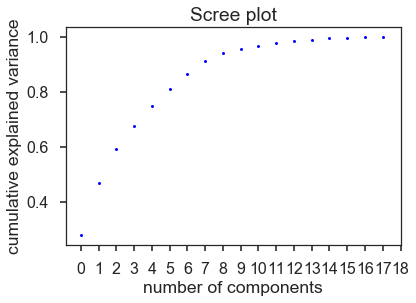

In [12]:
#performing PCA on the data
from sklearn.decomposition import PCA

pca = PCA().fit(X_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_),'o',mfc='b',ms=3)
plt.xticks(np.arange(0,19))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('Scree plot')
plt.show()

From the scree plot we can see that 10 principal components explain nearly 95% of the variance in the data. Hence, I will reduce the dimension of the data to 10 by selecting the first 10 principal components.

In [13]:
pca2 = PCA(n_components=10)
X_pca = pca2.fit_transform(X_scaled)
print ('variance explained by 10 principal components : ',pca2.explained_variance_ratio_.sum()*100)

variance explained by 10 principal components :  95.5091563473


In [14]:
#Creating a dataframe for these principal components
ensemble_PCA=pd.DataFrame()

for i in range(pca2.explained_variance_ratio_.shape[0]):
    ensemble_PCA["pc%i" % (i+1)] = X_pca[:,i]
ensemble_PCA['target']=y
ensemble_PCA.head()

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,target
0,0.906567,-0.299441,0.074259,-0.014117,0.031499,-0.268704,-0.162741,-0.061765,-0.063745,0.236158,0.0
1,1.048330,-0.210562,0.217755,-0.096268,-0.214130,-0.051432,0.738886,0.091212,-0.011158,0.147344,0.0
2,-0.321950,-0.780360,-0.305274,0.067189,-0.118860,-0.041936,0.047054,0.024651,-0.045458,-0.008474,0.0
3,0.114427,0.423001,-0.669910,0.118264,-0.489234,-0.309680,-0.081379,-0.182168,-0.045315,0.265932,0.0
4,1.046077,-0.230247,0.219552,-0.111123,-0.228974,-0.060534,0.740836,0.083058,-0.011466,-0.096351,0.0


Now, ensemble_PCA is the new dataframe containing the transformed features (first 10 principal components) and the corresponding responses.

# 1.4 Splitting the data into train and test

Now, I will split the new dataframe ensemble_PCA into train and test dataframes using stratified splitting so that the ratio of minority(1) and majority(0) class in the train and test dataframes remains the same.

In [15]:
#Splitting the data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(ensemble_PCA.iloc[:,:10],ensemble_PCA['target'],
                                                  test_size=0.30,stratify=ensemble_PCA['target']
                                                  ,random_state=999)

In [16]:
print('ratio of 1:0 class in training set',y_train.value_counts()[1]/y_train.value_counts()[0])
print('ratio of 1:0 class in test set',y_train.value_counts()[1]/y_train.value_counts()[0])

ratio of 1:0 class in training set 0.123548833742
ratio of 1:0 class in test set 0.123548833742


In [17]:
#Concating the X_train and y_train to form one training dataset
train_frames=[X_train,y_train]
ensemble_train=pd.concat(train_frames,axis=1)
ensemble_train.head()

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,target
12419,0.355327,-0.710004,-0.138183,-0.185353,0.586816,0.141260,-0.041018,0.061662,0.903877,-0.042080,0.0
3027,0.752689,0.481100,-0.437002,-0.319608,0.073395,-0.197283,-0.151311,-0.137164,-0.049416,0.171403,0.0
6388,0.890769,-0.322564,0.070270,-0.041717,0.006791,-0.295778,-0.154801,-0.077963,-0.071765,-0.151536,0.0
745,-0.765284,-0.365797,0.483895,-0.010198,-0.058203,-0.078492,-0.028430,-0.039593,0.019278,0.026935,0.0
3130,0.110450,0.564059,-0.691376,0.313883,-0.391179,-0.399044,-0.188518,0.791995,-0.078386,0.256435,0.0


After feature selection, the next section focusses on building classification models on the data

In [18]:
ensemble_train.target.value_counts()

0.0    9389
1.0    1160
Name: target, dtype: int64

# 1.5 Building Classification Models

## 1.5.1 Defining some important functions for Classification

### 1.5.1.1 Funtions to perform Classfication

In [80]:
#Creating a f1 scoring function
f1 = make_scorer(f1_score,average='weighted')

In [83]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold

def cv_optimize(clf, parameters, X, y, n_jobs=-1, n_folds=5):
    
    """
    Funtion cv_optimize
    ------------------------
    This function perform cross-validation using Grid search and is used for hyperparameter tuning
    and model selection. This function is called in the do_classify function which performs the 
    classification. 
    
    Parameters
    ------------------------
    clf          : The classifier
    parameters   : A dictionary of parameters on which grid search is to be performed
    X            : Dataframe of features
    y            : A Dataframe of responses/target
    n_jobs       : Parameter for number of cores to engage when performing cv
    n_folds      : The number of cv folds
    
    
    Returns
    -------------------------
    best : The best hyperparameters for the classifier
    """
    
    skf = StratifiedKFold(n_splits=n_folds, shuffle = True, random_state = 999)
    
    gs = GridSearchCV(clf, param_grid=parameters, cv=skf.split(X,y), n_jobs=n_jobs, 
                          scoring=f1)
    
    gs.fit(X, y)
    
    print ("BEST", gs.best_params_, gs.best_score_, gs.grid_scores_)
    
    best = gs.best_estimator_
    
    return best

#######################################################################################

def do_classify(clf, parameters, Xtrain,Xtest,ytrain,ytest, n_folds=5, 
                n_jobs=-1):
    """
    Funtion do_classify
    ------------------------
    This function performs classification using the best hyperparameters, which are determined
    using cv_optimize and then tests the model on the test set. This function prints the training
    and test accuracy of the classifier and plots the confusion matrix.
    
    Parameters
    ------------------------
    clf          : The classifier
    parameters   : A dictionary of parameters on which grid search is to be performed
    Xtrain       : Train Dataframe of features
    Xtest        : Test Dataframe of features
    ytrain       : Train Dataframe of responses/target
    ytest        : Test Dataframe of responses/target
    n_jobs       : Parameter for number of cores to engage when performing cv
    n_folds      : The number of cv folds
    
    
    Returns
    -------------------------
    clf          : The classifier with optimized hyperparameters
    Xtrain       : The Train Dataframe of features
    Xtest        : The Test Dataframe of features
    ytrain       : The Train Dataframe of responses/target
    ytest        : The Test Dataframe of responses/target
    
    Prints the training and test accuracy.
    Plots the confusion matrix.
    """
    #performing grid search to find best hyperparameters
    
    f1 = make_scorer(f1_score,average='weighted')

    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds)
    
    # Fitting the tuned classifier
    clf=clf.fit(Xtrain, ytrain)
    
    # Calculating the training accuracy
    training_accuracy = clf.score(Xtrain, ytrain)
    
    # Calculating the test accuracy
    test_accuracy = clf.score(Xtest, ytest)
    
        
    print ("############# based on standard predict ################")
    print ("Accuracy on training data: %0.2f" % (training_accuracy))
    print ("Accuracy on test data:     %0.2f" % (test_accuracy))
    
    #Calculating the confusion matrix
    cnf_matrix = confusion_matrix(ytest, clf.predict(Xtest))
    np.set_printoptions(precision=3)
    
    plt.figure()
    
    #Plotting the confusion matrix
    plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix, without normalization')
    plt.show()
    print ("########################################################")
    
    return clf, Xtrain, ytrain, Xtest, ytest

### 1.5.1.2 Functions for plotting confusion matrix and ROC curve

In [20]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Funtion plot_confusion_matrix
    -----------------------------
    This function plots the confusion matrix.
    
    Parameters
    ------------------------
    cm              : The confusion matrix to be plotted
    normalization   : A boolean value for normalizing the values in confusion matrix
    title           : Title of the plot
    cmap            : The color map to be used
    
    Returns
    -------------------------
    Plots the confusion matrix.
    
    PS-This function in called in do_classify.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

###############################################################################################    

def make_pr(name, clf, ytest, xtest, ax=None):
    
    """
    Funtion make_roc
    -----------------------------
    This function plots the ROC curve and also prints the AUC(Area Under the Curve).
    
    Parameters
    ------------------------
    name  : Name of the classifier in strings
    clf   : The tuned classifier
    ytest : The true responses in the test set
    xtest : Features of the test set
    ax    : The number of ROC curves to print
    
    
    Returns
    -------------------------
    ax: Plots the ROC curve along with AUC value.
    
    PS: Code taken from http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
    """
   
    average_precision = average_precision_score(ytest, clf.predict_proba(xtest)[:,1])
    
    precision, recall, _ = precision_recall_curve(y_test, clf.predict_proba(xtest)[:,1])

    plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
    
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
    
    

### 1.5.1.3 Functions for performing Resampling

In [21]:
def RUS(train_df,Xtrain,ytrain,minority_ratio=0.5):
    
    """
    Funtion RUS
    -----------------------------
    This function performs Random Under Sampling without replacement on the data.
    
    Parameters
    ------------------------
    train_df       : The dataframe on which Random under sampling is to be performed
    Xtrain         : Dataframe containing only training features
    ytrain         : A dataframe of training responses
    minority_ratio : The ratio of minority class to be kept after resampling
    
    Returns
    -------------------------
    train_df : A dataframe with resampled datapoints.
    """
    
    #Find number of samples which are 1
    ones = len(ytrain[ytrain==1])
    
    #Calcuating total observations in the dataset
    total_classes = round(ones/minority_ratio)
    
    #Calculating total number of majority classes
    majority_number = round(total_classes*(1-minority_ratio))
    
    #get indices of zeros
    zero_indices= ytrain[ytrain==0].index
    
    #random sample indices of datapoints having class 0
    random_indices_zero = np.random.choice(zero_indices, majority_number, replace=False)
    
    #get the indices of samples which are 1
    one_indices = ytrain[ytrain==1].index
    
    #concatenate indices as class 1 with sample 0 
    US_indices = np.concatenate([one_indices,random_indices_zero])
    
    return train_df.loc[US_indices]

In [22]:
from imblearn.over_sampling import SMOTE

def SMOTE_(Xtrain,ytrain,r,rs=999):
    """
    Funtion SMOTE
    -----------------------------
    This function performs SMOTE on the data.
    
    Parameters
    ------------------------
    Xtrain : Dataframe containing only training features
    ytrain : A dataframe of training responses
    r      : A dictionary specifying the ratio between the two classes
    rs     : Seed for random state
    
    Returns
    -------------------------
    SMOTE_train_frame : A dataframe with resampled datapoints.
    
    PS :  For a ratio of 50:50 for 1:0 use dictionary { 0:9389, 1:9389 } as a value for r
          For a ratio of 30:70 for 1:0 use dictionary { 0:9389, 1:4023 } as a value for r
    """
    #Creating a SMOTE object   
    sm=SMOTE(ratio=r,random_state=rs)
    
    #Fitting the training X and y on the SMOTE object
    Xtrain_SMOTE, ytrain_SMOTE = sm.fit_sample(Xtrain,ytrain.ravel())
     
    #Creating a new resampled dataframe for training y
    ytrain_sm_df=pd.DataFrame(ytrain_SMOTE, columns=['target'])
    
    #Creating a new resampled dataframe for training X
    Xtrain_sm_df=pd.DataFrame()
    for i in range(Xtrain_SMOTE.shape[1]):
        Xtrain_sm_df["pc%i" % (i+1)] = Xtrain_SMOTE[:,i]
    
    #Concatenating the two dataframes to get a final training dataframes
    SMOTE_train_frame=pd.concat([ Xtrain_sm_df, ytrain_sm_df ],axis=1)
    
    return SMOTE_train_frame

In [23]:
from imblearn.over_sampling import RandomOverSampler

def ROS(Xtrain,ytrain,r,rs=999):
    
    """
    Funtion RUS
    -----------------------------
    This function performs random over-sampling on the data.
    
    Parameters
    ------------------------
    Xtrain : Dataframe containing only training features
    ytrain : A dataframe of training responses
    r      : A dictionary specifying the ratio between the two classes
    rs     : Seed for random state
    
    Returns
    -------------------------
    ros_train_frame : A dataframe with resampled datapoints.
    
    PS :  For a ratio of 50:50 for 1:0 use dictionary { 0:9389, 1:9389 } as a value for r
          For a ratio of 30:70 for 1:0 use dictionary { 0:9389, 1:4023 } as a value for r
    """
    #Creating a RandomOverSampler object
    ros=RandomOverSampler(ratio=r,random_state=rs)
    
    #Fitting the training X and y on the RandomOverSampler object
    Xtrain_ros, ytrain_ros = ros.fit_sample(Xtrain,ytrain.ravel())
    
    #Creating a new resampled dataframe for training X
    ytrain_ros_df=pd.DataFrame(ytrain_ros, columns=['target'])
    
    #Creating a new resampled dataframe for training X
    Xtrain_ros_df=pd.DataFrame()
    for i in range(Xtrain_ros.shape[1]):
        Xtrain_ros_df["pc%i" % (i+1)] = Xtrain_ros[:,i]
    
    #Concatenating the two dataframes to get a final training dataframes
    ros_train_frame=pd.concat([ Xtrain_ros_df, ytrain_ros_df ],axis=1)
    
    return ros_train_frame

## 1.5.2 Constructing re-sampling Data sets

In this section, I construct resampling datasets on which different classifiers will be fit.

### 1.5.2.1 Different resampling datasets having different class ratios

In [24]:
#Random undersampling train data having 1:0 ratio as 50:50
rus_train_50 = RUS(ensemble_train,X_train,y_train,0.5)

#Random undersampling train data having 1:0 ratio as 30:70
rus_train_30 = RUS(ensemble_train,X_train,y_train,0.3)

#Random oversampling train data having 1:0 ratio as 50:50
ros_train_50 = ROS(X_train,y_train,{ 0:9389, 1:9389 })

#Random oversampling train data having 1:0 ratio as 30:70
ros_train_30 = ROS(X_train,y_train,{ 0:9389, 1:4023 })

#SMOTE train data having 1:0 ratio as 50:50
smote_train_50 = SMOTE_(X_train,y_train,{ 0:9389, 1:9389 })

#SMOTE train data having 1:0 ratio as 30:70
smote_train_30 = SMOTE_(X_train,y_train,{ 0:9389, 1:4023 })

### 1.5.2.2 Plotting the above dataframes

Plotting the above created dataframes to verify the distribution of classes

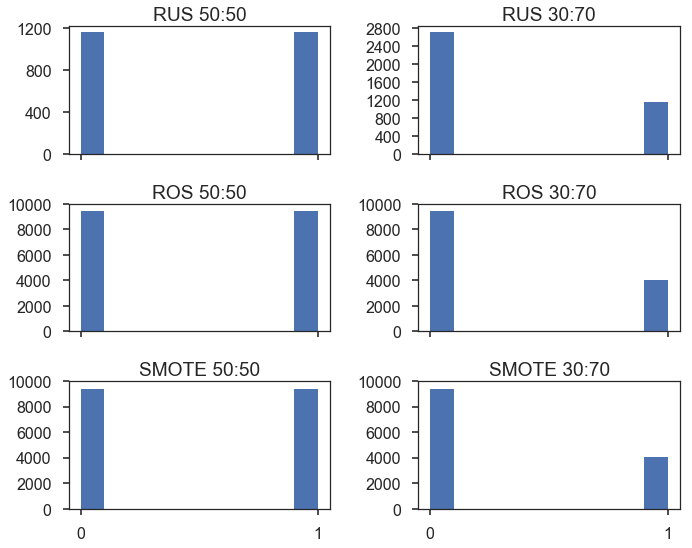

In [25]:
fig,ax=plt.subplots(3,2,figsize=(10,8),sharex=True)

ax[0,0].hist(rus_train_50.target)
ax[0,0].set(title='RUS 50:50')
ax[0,0].set_xticks(range(0,2))
ax[0,0].set_yticks(range(0,1300,400))

ax[0,1].hist(rus_train_30.target)
ax[0,1].set(title='RUS 30:70')
ax[0,1].set_xticks(range(0,2))
ax[0,1].set_yticks(range(0,3000,400))

ax[1,0].hist(ros_train_50.target)
ax[1,0].set(title='ROS 50:50')
ax[1,0].set_xticks(range(0,2))
ax[1,0].set_yticks(range(0,12000,2000))

ax[1,1].hist(ros_train_30.target)
ax[1,1].set(title='ROS 30:70')
ax[1,1].set_xticks(range(0,2))
ax[1,1].set_yticks(range(0,12000,2000))

ax[2,0].hist(smote_train_50.target)
ax[2,0].set(title='SMOTE 50:50')
ax[2,0].set_xticks(range(0,2))
ax[2,0].set_yticks(range(0,12000,2000))

ax[2,1].hist(smote_train_30.target)
ax[2,1].set(title='SMOTE 30:70')
ax[2,1].set_xticks(range(0,2))
ax[2,1].set_yticks(range(0,12000,2000))

plt.tight_layout()
plt.show()

### 1.5.2.3 Creating Xtrain and ytrain dataframes from the resampled datasets

The resampled training dataset created above are subsetted here into their respective features and response dataframes for classification

In [26]:
X_train_rus_50 = rus_train_50.iloc[:,:10];             y_train_rus_50 = rus_train_50.iloc[:,10]
X_train_rus_30 = rus_train_30.iloc[:,:10];             y_train_rus_30 = rus_train_30.iloc[:,10]

X_train_ros_50 = ros_train_50.iloc[:,:10];             y_train_ros_50 = ros_train_50.iloc[:,10]
X_train_ros_30 = ros_train_30.iloc[:,:10];             y_train_ros_30 = ros_train_30.iloc[:,10]

X_train_smote_50 = smote_train_50.iloc[:,:10];         y_train_smote_50 = smote_train_50.iloc[:,10]
X_train_smote_30 = smote_train_30.iloc[:,:10];         y_train_smote_30 = smote_train_30.iloc[:,10]

## 1.5.3 Model building

### 1.5.3.1 Logistic Regression

In [27]:
from sklearn.linear_model import LogisticRegression

#### 1.5.3.1.1 Fitting LR on RUS dataset having a sampling ratio of 50:50 (Minority:Majority) 

BEST {'C': 1, 'penalty': 'l2'} 0.73872998996 [mean: 0.73525, std: 0.01026, params: {'C': 0.01, 'penalty': 'l2'}, mean: 0.64760, std: 0.01796, params: {'C': 0.01, 'penalty': 'l1'}, mean: 0.73698, std: 0.00841, params: {'C': 0.1, 'penalty': 'l2'}, mean: 0.73656, std: 0.00965, params: {'C': 0.1, 'penalty': 'l1'}, mean: 0.73873, std: 0.00885, params: {'C': 1, 'penalty': 'l2'}, mean: 0.73744, std: 0.00819, params: {'C': 1, 'penalty': 'l1'}, mean: 0.73742, std: 0.00747, params: {'C': 10, 'penalty': 'l2'}, mean: 0.73700, std: 0.00825, params: {'C': 10, 'penalty': 'l1'}, mean: 0.73743, std: 0.00852, params: {'C': 100, 'penalty': 'l2'}, mean: 0.73743, std: 0.00852, params: {'C': 100, 'penalty': 'l1'}, mean: 0.73786, std: 0.00886, params: {'C': 1000, 'penalty': 'l2'}, mean: 0.73786, std: 0.00886, params: {'C': 1000, 'penalty': 'l1'}]
############# based on standard predict ################
Accuracy on training data: 0.74
Accuracy on test data:     0.74
Confusion matrix, without normalization
[[3

C:\Users\musta\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


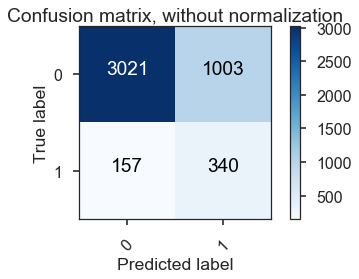

########################################################
--- 9.856708526611328 seconds ---


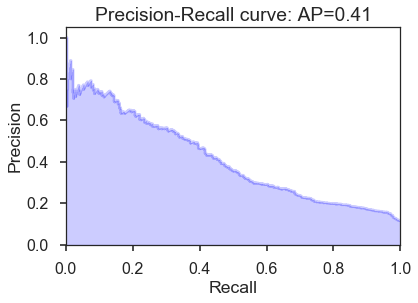

In [84]:
start_time = time.time()
clflog_rus_50 = LogisticRegression(class_weight='balanced')

#GridSearchCV parameters
parameters = {"C": [0.01, 0.1, 1, 10, 100, 1000],
             "penalty":['l2','l1']}

# parameters = {'C': [0.1], 'penalty': ['l2']}

clflog_rus_50, Xtrain, ytrain, Xtest, ytest = do_classify(clflog_rus_50,parameters,X_train_rus_50,
                                                   X_test,y_train_rus_50,y_test)

make_pr("clflog",clflog_rus_50, ytest, Xtest)

print("--- %s seconds ---" % (time.time() - start_time))

In [85]:
#printing the classification report
print(classification_report(y_test, clflog_rus_50.predict(X_test) , target_names=['0','1']))

             precision    recall  f1-score   support

          0       0.95      0.75      0.84      4024
          1       0.25      0.68      0.37       497

avg / total       0.87      0.74      0.79      4521



#### 1.5.3.1.2 Fitting LR on RUS dataset having a sampling ratio of 30:70 (Minority:Majority)

BEST {'C': 10, 'penalty': 'l1'} 0.763002438763 [mean: 0.76243, std: 0.00993, params: {'C': 0.01, 'penalty': 'l2'}, mean: 0.69395, std: 0.00916, params: {'C': 0.01, 'penalty': 'l1'}, mean: 0.76090, std: 0.00896, params: {'C': 0.1, 'penalty': 'l2'}, mean: 0.76107, std: 0.00858, params: {'C': 0.1, 'penalty': 'l1'}, mean: 0.76283, std: 0.00853, params: {'C': 1, 'penalty': 'l2'}, mean: 0.76259, std: 0.00843, params: {'C': 1, 'penalty': 'l1'}, mean: 0.76277, std: 0.00851, params: {'C': 10, 'penalty': 'l2'}, mean: 0.76300, std: 0.00883, params: {'C': 10, 'penalty': 'l1'}, mean: 0.76300, std: 0.00883, params: {'C': 100, 'penalty': 'l2'}, mean: 0.76300, std: 0.00883, params: {'C': 100, 'penalty': 'l1'}, mean: 0.76300, std: 0.00883, params: {'C': 1000, 'penalty': 'l2'}, mean: 0.76300, std: 0.00883, params: {'C': 1000, 'penalty': 'l1'}]
############# based on standard predict ################
Accuracy on training data: 0.76
Accuracy on test data:     0.74
Confusion matrix, without normalization
[

C:\Users\musta\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


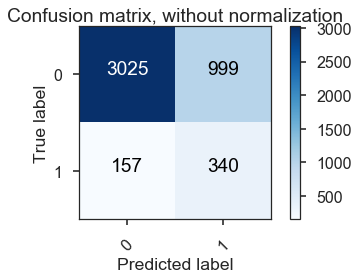

########################################################
--- 9.168876886367798 seconds ---


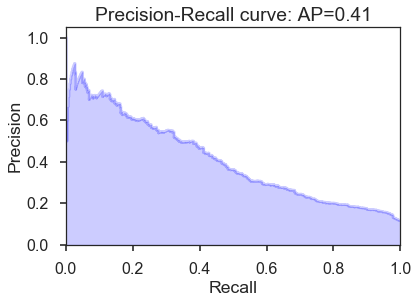

In [86]:
start_time = time.time()
clflog_rus_30 = LogisticRegression(class_weight='balanced')

#GridSearchCv parameters
parameters = {"C": [0.01, 0.1, 1, 10, 100, 1000],
             "penalty":['l2','l1']}

# parameters = {'C': [10], 'penalty': ['l1']}

clflog_rus_30, Xtrain, ytrain, Xtest, ytest = do_classify(clflog_rus_30,parameters,X_train_rus_30,
                                                   X_test,y_train_rus_30,y_test)

make_pr("clflog",clflog_rus_30, ytest, Xtest)

print("--- %s seconds ---" % (time.time() - start_time))

In [87]:
#printing the classification report
print(classification_report(y_test, clflog_rus_30.predict(X_test) , target_names=['0','1']))

             precision    recall  f1-score   support

          0       0.95      0.75      0.84      4024
          1       0.25      0.68      0.37       497

avg / total       0.87      0.74      0.79      4521



#### 1.5.3.1.3 Fitting LR on ROS dataset having a sampling ratio of 50:50 (Minority:Majority)

BEST {'C': 0.1, 'penalty': 'l2'} 0.748575600448 [mean: 0.73532, std: 0.00385, params: {'C': 0.001, 'penalty': 'l2'}, mean: 0.66208, std: 0.00553, params: {'C': 0.001, 'penalty': 'l1'}, mean: 0.74793, std: 0.00483, params: {'C': 0.01, 'penalty': 'l2'}, mean: 0.74219, std: 0.00581, params: {'C': 0.01, 'penalty': 'l1'}, mean: 0.74858, std: 0.00477, params: {'C': 0.1, 'penalty': 'l2'}, mean: 0.74842, std: 0.00513, params: {'C': 0.1, 'penalty': 'l1'}, mean: 0.74820, std: 0.00544, params: {'C': 1, 'penalty': 'l2'}, mean: 0.74767, std: 0.00532, params: {'C': 1, 'penalty': 'l1'}, mean: 0.74799, std: 0.00532, params: {'C': 10, 'penalty': 'l2'}, mean: 0.74778, std: 0.00529, params: {'C': 10, 'penalty': 'l1'}, mean: 0.74778, std: 0.00529, params: {'C': 100, 'penalty': 'l2'}, mean: 0.74778, std: 0.00529, params: {'C': 100, 'penalty': 'l1'}, mean: 0.74778, std: 0.00529, params: {'C': 1000, 'penalty': 'l2'}, mean: 0.74778, std: 0.00529, params: {'C': 1000, 'penalty': 'l1'}]
############# based on st

C:\Users\musta\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


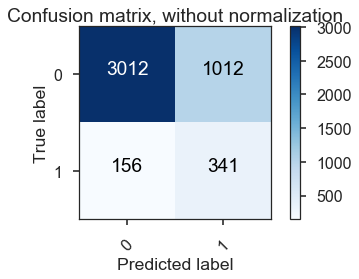

########################################################
--- 10.975720167160034 seconds ---


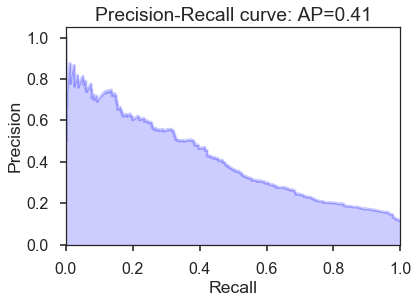

In [88]:
start_time = time.time()
clflog_ros_50 = LogisticRegression(class_weight='balanced')

#GridSearchCv parameters
parameters = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
             "penalty":['l2','l1']}

# parameters = {'C': [0.01], 'penalty': ['l2']}

clflog_ros_50, Xtrain, ytrain, Xtest, ytest = do_classify(clflog_ros_50,parameters,X_train_ros_50,
                                                   X_test,y_train_ros_50,y_test)

make_pr("clflog",clflog_ros_50, ytest, Xtest)

print("--- %s seconds ---" % (time.time() - start_time))

In [33]:
#printing the classification report
print(classification_report(y_test, clflog_ros_50.predict(X_test) , target_names=['0','1']))

             precision    recall  f1-score   support

          0       0.95      0.74      0.83      4024
          1       0.25      0.69      0.36       497

avg / total       0.87      0.74      0.78      4521



#### 1.5.3.1.4 Fitting LR on ROS dataset having a sampling ratio of 30:70 (Minority:Majority)

BEST {'C': 1, 'penalty': 'l1'} 0.755872767242 [mean: 0.75260, std: 0.00432, params: {'C': 0.01, 'penalty': 'l2'}, mean: 0.74313, std: 0.00564, params: {'C': 0.01, 'penalty': 'l1'}, mean: 0.75385, std: 0.00314, params: {'C': 0.1, 'penalty': 'l2'}, mean: 0.75432, std: 0.00386, params: {'C': 0.1, 'penalty': 'l1'}, mean: 0.75573, std: 0.00406, params: {'C': 1, 'penalty': 'l2'}, mean: 0.75587, std: 0.00412, params: {'C': 1, 'penalty': 'l1'}, mean: 0.75579, std: 0.00403, params: {'C': 10, 'penalty': 'l2'}, mean: 0.75571, std: 0.00412, params: {'C': 10, 'penalty': 'l1'}, mean: 0.75571, std: 0.00412, params: {'C': 100, 'penalty': 'l2'}, mean: 0.75571, std: 0.00412, params: {'C': 100, 'penalty': 'l1'}, mean: 0.75578, std: 0.00413, params: {'C': 1000, 'penalty': 'l2'}, mean: 0.75578, std: 0.00413, params: {'C': 1000, 'penalty': 'l1'}]
############# based on standard predict ################
Accuracy on training data: 0.75
Accuracy on test data:     0.74
Confusion matrix, without normalization
[[

C:\Users\musta\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


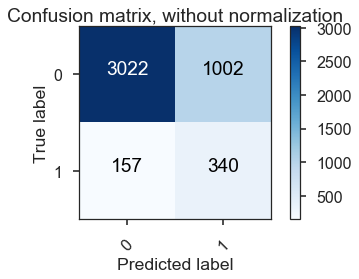

########################################################
--- 9.470714569091797 seconds ---


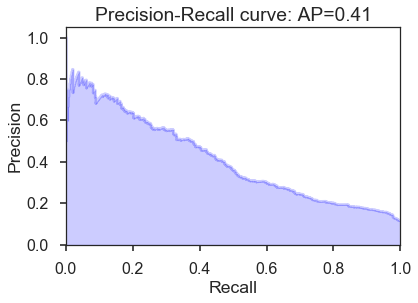

In [89]:
start_time = time.time()
clflog_ros_30 = LogisticRegression(class_weight='balanced')

#GridSearchCV parameters
parameters = {"C": [0.01, 0.1, 1, 10, 100, 1000],
             "penalty":['l2','l1']}

# parameters = {'C': [0.1], 'penalty': ['l2']}

clflog_ros_30, Xtrain, ytrain, Xtest, ytest = do_classify(clflog_ros_30,parameters,X_train_ros_30,
                                                   X_test,y_train_ros_30,y_test)

make_pr("clflog",clflog_ros_30, ytest, Xtest)

print("--- %s seconds ---" % (time.time() - start_time))

In [91]:
#printing the classification report
print(classification_report(y_test, clflog_ros_30.predict(X_test) , target_names=['0','1']))

             precision    recall  f1-score   support

          0       0.95      0.75      0.84      4024
          1       0.25      0.68      0.37       497

avg / total       0.87      0.74      0.79      4521



#### 1.5.3.1.5 Fitting LR on SMOTE dataset having a sampling ratio of 50:50 (Minority:Majority)

BEST {'C': 0.1, 'penalty': 'l1'} 0.752460620599 [mean: 0.75033, std: 0.00527, params: {'C': 0.01, 'penalty': 'l2'}, mean: 0.74644, std: 0.00729, params: {'C': 0.01, 'penalty': 'l1'}, mean: 0.75214, std: 0.00541, params: {'C': 0.1, 'penalty': 'l2'}, mean: 0.75246, std: 0.00528, params: {'C': 0.1, 'penalty': 'l1'}, mean: 0.75155, std: 0.00577, params: {'C': 1, 'penalty': 'l2'}, mean: 0.75133, std: 0.00584, params: {'C': 1, 'penalty': 'l1'}, mean: 0.75096, std: 0.00548, params: {'C': 10, 'penalty': 'l2'}, mean: 0.75090, std: 0.00550, params: {'C': 10, 'penalty': 'l1'}, mean: 0.75096, std: 0.00543, params: {'C': 100, 'penalty': 'l2'}, mean: 0.75096, std: 0.00543, params: {'C': 100, 'penalty': 'l1'}, mean: 0.75096, std: 0.00543, params: {'C': 1000, 'penalty': 'l2'}, mean: 0.75096, std: 0.00543, params: {'C': 1000, 'penalty': 'l1'}]
############# based on standard predict ################
Accuracy on training data: 0.75
Accuracy on test data:     0.75
Confusion matrix, without normalization


C:\Users\musta\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


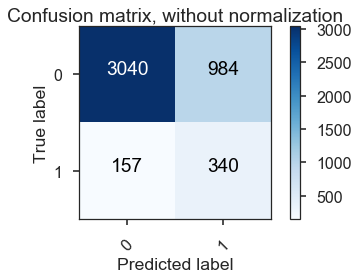

########################################################
--- 11.353663682937622 seconds ---


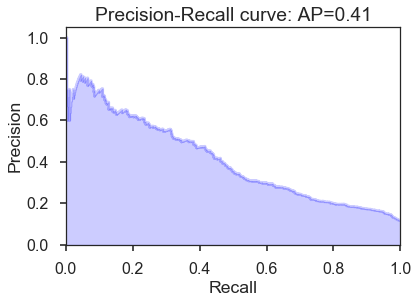

In [90]:
start_time = time.time()
clflog_smote_50 = LogisticRegression(class_weight='balanced')

#GridSearchCV parameters
parameters = {"C": [0.01, 0.1, 1, 10, 100, 1000], "penalty":['l2','l1']}

# parameters = {'C': [0.01], 'penalty': ['l1']}

clflog_smote_50, Xtrain, ytrain, Xtest, ytest = do_classify(clflog_smote_50,parameters,
                                                            X_train_smote_50, X_test,
                                                            y_train_smote_50,y_test)

make_pr("clflog",clflog_smote_50, ytest, Xtest)

print("--- %s seconds ---" % (time.time() - start_time))

In [92]:
#printing the classification report
print(classification_report(y_test, clflog_smote_50.predict(X_test) , target_names=['0','1']))

             precision    recall  f1-score   support

          0       0.95      0.76      0.84      4024
          1       0.26      0.68      0.37       497

avg / total       0.87      0.75      0.79      4521



#### 2.5.3.1.6 Fitting LR on SMOTE dataset having a sampling ratio of 30:70 (Minority:Majority)

BEST {'C': 1, 'penalty': 'l1'} 0.758493150466 [mean: 0.75348, std: 0.00317, params: {'C': 0.01, 'penalty': 'l2'}, mean: 0.74509, std: 0.00511, params: {'C': 0.01, 'penalty': 'l1'}, mean: 0.75729, std: 0.00244, params: {'C': 0.1, 'penalty': 'l2'}, mean: 0.75758, std: 0.00262, params: {'C': 0.1, 'penalty': 'l1'}, mean: 0.75838, std: 0.00265, params: {'C': 1, 'penalty': 'l2'}, mean: 0.75849, std: 0.00262, params: {'C': 1, 'penalty': 'l1'}, mean: 0.75827, std: 0.00272, params: {'C': 10, 'penalty': 'l2'}, mean: 0.75834, std: 0.00268, params: {'C': 10, 'penalty': 'l1'}, mean: 0.75834, std: 0.00268, params: {'C': 100, 'penalty': 'l2'}, mean: 0.75834, std: 0.00268, params: {'C': 100, 'penalty': 'l1'}, mean: 0.75834, std: 0.00268, params: {'C': 1000, 'penalty': 'l2'}, mean: 0.75834, std: 0.00268, params: {'C': 1000, 'penalty': 'l1'}]
############# based on standard predict ################
Accuracy on training data: 0.75
Accuracy on test data:     0.75
Confusion matrix, without normalization
[[

C:\Users\musta\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


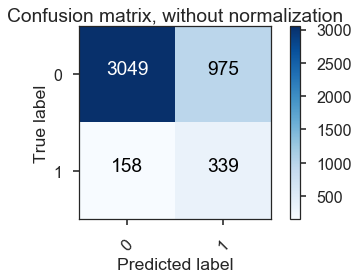

########################################################
--- 9.534596681594849 seconds ---


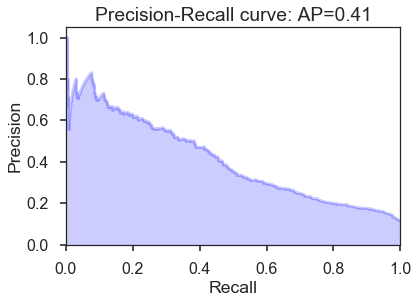

In [93]:
start_time = time.time()
clflog_smote_30 = LogisticRegression(class_weight='balanced')

#GridSearchCV
parameters = {"C": [0.01, 0.1, 1, 10, 100, 1000], "penalty":['l2','l1']}

# parameters = {'C': [0.1], 'penalty': ['l1']}

clflog_smote_30, Xtrain, ytrain, Xtest, ytest = do_classify(clflog_smote_30,parameters,
                                                            X_train_smote_30, X_test,
                                                            y_train_smote_30,y_test)

make_pr("clflog",clflog_smote_30, ytest, Xtest)

print("--- %s seconds ---" % (time.time() - start_time))

### 1.5.3.2 Decision Tree

In [39]:
from sklearn import tree

#### 2.5.3.2.1 Fitting DT on RUS dataset having a sampling ratio of 50:50 (Minority:Majority)

BEST {'max_depth': 5, 'min_samples_leaf': 3} 0.734068752871 [mean: 0.63334, std: 0.01190, params: {'max_depth': 1, 'min_samples_leaf': 1}, mean: 0.63334, std: 0.01190, params: {'max_depth': 1, 'min_samples_leaf': 2}, mean: 0.63334, std: 0.01190, params: {'max_depth': 1, 'min_samples_leaf': 3}, mean: 0.63334, std: 0.01190, params: {'max_depth': 1, 'min_samples_leaf': 4}, mean: 0.63334, std: 0.01190, params: {'max_depth': 1, 'min_samples_leaf': 5}, mean: 0.63334, std: 0.01190, params: {'max_depth': 1, 'min_samples_leaf': 6}, mean: 0.65920, std: 0.02196, params: {'max_depth': 2, 'min_samples_leaf': 1}, mean: 0.65920, std: 0.02196, params: {'max_depth': 2, 'min_samples_leaf': 2}, mean: 0.65920, std: 0.02196, params: {'max_depth': 2, 'min_samples_leaf': 3}, mean: 0.65920, std: 0.02196, params: {'max_depth': 2, 'min_samples_leaf': 4}, mean: 0.65920, std: 0.02196, params: {'max_depth': 2, 'min_samples_leaf': 5}, mean: 0.65920, std: 0.02196, params: {'max_depth': 2, 'min_samples_leaf': 6}, mea

C:\Users\musta\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


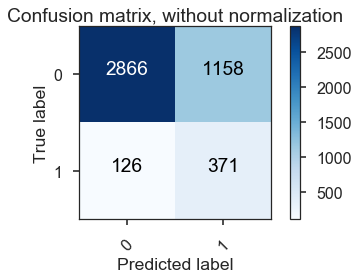

########################################################
             precision    recall  f1-score   support

          0       0.96      0.71      0.82      4024
          1       0.24      0.75      0.37       497

avg / total       0.88      0.72      0.77      4521

--- 9.280802965164185 seconds ---


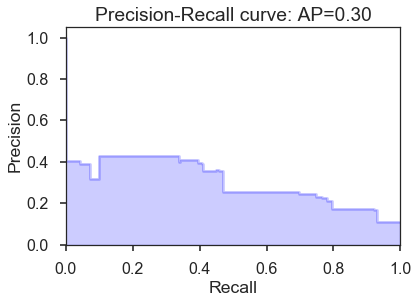

In [94]:
start_time = time.time()
clfdt = tree.DecisionTreeClassifier()

#GridSearchCV parameters
parameters = {"max_depth": [1, 2, 3, 4, 5, 6, 7], 'min_samples_leaf': [1, 2, 3, 4, 5, 6]}

# parameters={'max_depth': [3], 'min_samples_leaf': [1]}

clfdt_rus_50, Xtrain, ytrain, Xtest, ytest= do_classify(clfdt, parameters, X_train_rus_50, X_test,
                                                  y_train_rus_50, y_test)

make_pr("clfdt",clfdt_rus_50, ytest, Xtest)

print(classification_report(y_test, clfdt_rus_50.predict(X_test) , target_names=['0','1']))

print("--- %s seconds ---" % (time.time() - start_time))

#### 1.5.3.2.2 Fitting DT on RUS dataset having a sampling ratio of 30:70 (Minority:Majority)

C:\Users\musta\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


BEST {'max_depth': 6, 'min_samples_leaf': 3} 0.767540814236 [mean: 0.74810, std: 0.00279, params: {'max_depth': 1, 'min_samples_leaf': 1}, mean: 0.74810, std: 0.00279, params: {'max_depth': 1, 'min_samples_leaf': 2}, mean: 0.74810, std: 0.00279, params: {'max_depth': 1, 'min_samples_leaf': 3}, mean: 0.74810, std: 0.00279, params: {'max_depth': 1, 'min_samples_leaf': 4}, mean: 0.74810, std: 0.00279, params: {'max_depth': 1, 'min_samples_leaf': 5}, mean: 0.74810, std: 0.00279, params: {'max_depth': 1, 'min_samples_leaf': 6}, mean: 0.74237, std: 0.00966, params: {'max_depth': 2, 'min_samples_leaf': 1}, mean: 0.74237, std: 0.00966, params: {'max_depth': 2, 'min_samples_leaf': 2}, mean: 0.74237, std: 0.00966, params: {'max_depth': 2, 'min_samples_leaf': 3}, mean: 0.74237, std: 0.00966, params: {'max_depth': 2, 'min_samples_leaf': 4}, mean: 0.74237, std: 0.00966, params: {'max_depth': 2, 'min_samples_leaf': 5}, mean: 0.74237, std: 0.00966, params: {'max_depth': 2, 'min_samples_leaf': 6}, mea

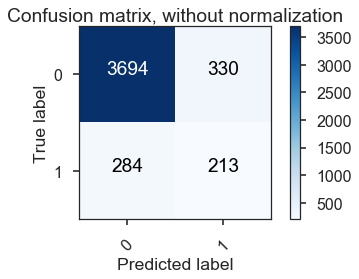

########################################################
             precision    recall  f1-score   support

          0       0.93      0.92      0.92      4024
          1       0.39      0.43      0.41       497

avg / total       0.87      0.86      0.87      4521

--- 9.948911905288696 seconds ---


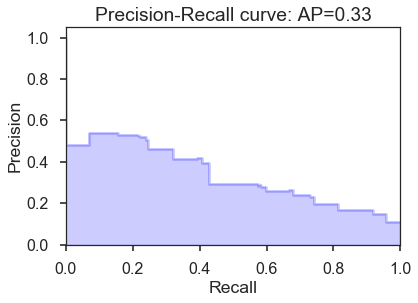

In [95]:
start_time = time.time()
clfdt = tree.DecisionTreeClassifier()

parameters = {"max_depth": [1, 2, 3, 4, 5, 6, 7,8], 'min_samples_leaf': [1, 2, 3, 4, 5, 6]}

# parameters = {'max_depth': [7], 'min_samples_leaf':[ 4]}

clfdt_rus_30, Xtrain, ytrain, Xtest, ytest= do_classify(clfdt, parameters, X_train_rus_30, X_test,
                                                  y_train_rus_30, y_test)

make_pr("clfdt",clfdt_rus_30, ytest, Xtest)

print(classification_report(y_test, clfdt_rus_30.predict(X_test) , target_names=['0','1']))

print("--- %s seconds ---" % (time.time() - start_time))

#### 1.5.3.2.3 Fitting DT on ROS dataset having a sampling ratio of 50:50 (Minority:Majority)

C:\Users\musta\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


BEST {'max_depth': 11, 'min_samples_leaf': 1} 0.851210029023 [mean: 0.72987, std: 0.00837, params: {'max_depth': 3, 'min_samples_leaf': 1}, mean: 0.72987, std: 0.00837, params: {'max_depth': 3, 'min_samples_leaf': 2}, mean: 0.72987, std: 0.00837, params: {'max_depth': 3, 'min_samples_leaf': 3}, mean: 0.72987, std: 0.00837, params: {'max_depth': 3, 'min_samples_leaf': 4}, mean: 0.72987, std: 0.00837, params: {'max_depth': 3, 'min_samples_leaf': 5}, mean: 0.72987, std: 0.00837, params: {'max_depth': 3, 'min_samples_leaf': 6}, mean: 0.76078, std: 0.00544, params: {'max_depth': 4, 'min_samples_leaf': 1}, mean: 0.76078, std: 0.00544, params: {'max_depth': 4, 'min_samples_leaf': 2}, mean: 0.76078, std: 0.00544, params: {'max_depth': 4, 'min_samples_leaf': 3}, mean: 0.76078, std: 0.00544, params: {'max_depth': 4, 'min_samples_leaf': 4}, mean: 0.76072, std: 0.00534, params: {'max_depth': 4, 'min_samples_leaf': 5}, mean: 0.76072, std: 0.00534, params: {'max_depth': 4, 'min_samples_leaf': 6}, me

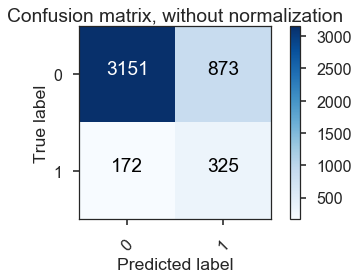

########################################################
             precision    recall  f1-score   support

          0       0.95      0.78      0.86      4024
          1       0.27      0.65      0.38       497

avg / total       0.87      0.77      0.81      4521

--- 12.570515155792236 seconds ---


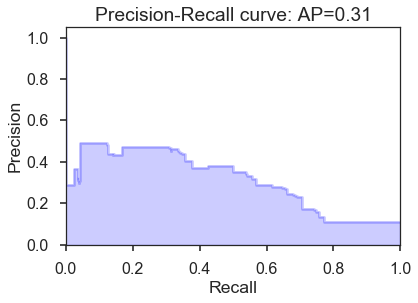

In [98]:
start_time = time.time()
clfdt = tree.DecisionTreeClassifier()

#GridSearchCV parameters
parameters = {"max_depth": [3,4,5,6,7,9,11], 'min_samples_leaf': [1, 2, 3, 4, 5, 6]}

# parameters = {'max_depth': [7], 'min_samples_leaf': [1]}

clfdt_ros_50, Xtrain, ytrain, Xtest, ytest= do_classify(clfdt, parameters, X_train_ros_50, X_test,
                                                  y_train_ros_50, y_test)

make_pr("clfdt",clfdt_ros_50, ytest, Xtest)

print(classification_report(y_test, clfdt_ros_50.predict(X_test) , target_names=['0','1']))

print("--- %s seconds ---" % (time.time() - start_time))

#### 2.5.3.2.4 Fitting DT on ROS dataset having a sampling ratio of 30:70 (Minority:Majority)

BEST {'max_depth': 7, 'min_samples_leaf': 1} 0.79636256849 [mean: 0.73941, std: 0.00734, params: {'max_depth': 1, 'min_samples_leaf': 1}, mean: 0.73941, std: 0.00734, params: {'max_depth': 1, 'min_samples_leaf': 2}, mean: 0.73941, std: 0.00734, params: {'max_depth': 1, 'min_samples_leaf': 3}, mean: 0.73941, std: 0.00734, params: {'max_depth': 1, 'min_samples_leaf': 4}, mean: 0.73941, std: 0.00734, params: {'max_depth': 1, 'min_samples_leaf': 5}, mean: 0.73941, std: 0.00734, params: {'max_depth': 1, 'min_samples_leaf': 6}, mean: 0.73808, std: 0.00718, params: {'max_depth': 2, 'min_samples_leaf': 1}, mean: 0.73808, std: 0.00718, params: {'max_depth': 2, 'min_samples_leaf': 2}, mean: 0.73808, std: 0.00718, params: {'max_depth': 2, 'min_samples_leaf': 3}, mean: 0.73808, std: 0.00718, params: {'max_depth': 2, 'min_samples_leaf': 4}, mean: 0.73808, std: 0.00718, params: {'max_depth': 2, 'min_samples_leaf': 5}, mean: 0.73808, std: 0.00718, params: {'max_depth': 2, 'min_samples_leaf': 6}, mean

C:\Users\musta\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


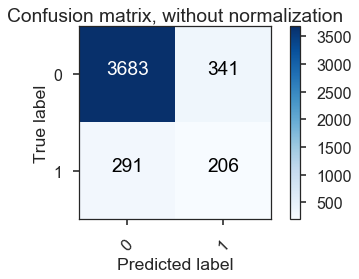

########################################################
             precision    recall  f1-score   support

          0       0.93      0.92      0.92      4024
          1       0.38      0.41      0.39       497

avg / total       0.87      0.86      0.86      4521

--- 10.643758296966553 seconds ---


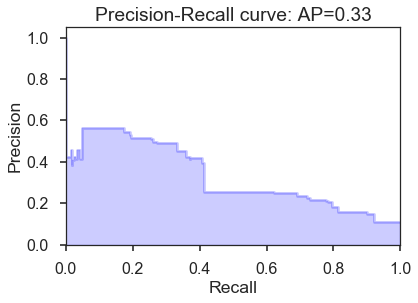

In [102]:
start_time = time.time()
clfdt = tree.DecisionTreeClassifier()

#GridSearch Parameters
parameters = {"max_depth": [1, 2, 3, 4, 5, 6, 7], 'min_samples_leaf': [1, 2, 3, 4, 5, 6]}

# parameters = {'max_depth': [7], 'min_samples_leaf': [2]}

clfdt_ros_30, Xtrain, ytrain, Xtest, ytest= do_classify(clfdt, parameters, X_train_ros_30, X_test,
                                                  y_train_ros_30, y_test)

make_pr("clfdt",clfdt_ros_30, ytest, Xtest)

print(classification_report(y_test, clfdt_ros_30.predict(X_test) , target_names=['0','1']))

print("--- %s seconds ---" % (time.time() - start_time))


#### 1.5.3.2.5 Fitting DT on SMOTE dataset having a sampling ratio of 50:50 (Minority:Majority)

C:\Users\musta\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


BEST {'max_depth': 21, 'min_samples_leaf': 1} 0.858070271905 [mean: 0.75243, std: 0.00644, params: {'max_depth': 4, 'min_samples_leaf': 1}, mean: 0.75243, std: 0.00644, params: {'max_depth': 4, 'min_samples_leaf': 2}, mean: 0.75232, std: 0.00653, params: {'max_depth': 4, 'min_samples_leaf': 3}, mean: 0.75232, std: 0.00653, params: {'max_depth': 4, 'min_samples_leaf': 4}, mean: 0.75232, std: 0.00653, params: {'max_depth': 4, 'min_samples_leaf': 5}, mean: 0.75232, std: 0.00653, params: {'max_depth': 4, 'min_samples_leaf': 6}, mean: 0.75232, std: 0.00653, params: {'max_depth': 4, 'min_samples_leaf': 7}, mean: 0.75237, std: 0.00646, params: {'max_depth': 4, 'min_samples_leaf': 8}, mean: 0.76692, std: 0.00605, params: {'max_depth': 5, 'min_samples_leaf': 1}, mean: 0.76698, std: 0.00609, params: {'max_depth': 5, 'min_samples_leaf': 2}, mean: 0.76703, std: 0.00605, params: {'max_depth': 5, 'min_samples_leaf': 3}, mean: 0.76703, std: 0.00605, params: {'max_depth': 5, 'min_samples_leaf': 4}, me

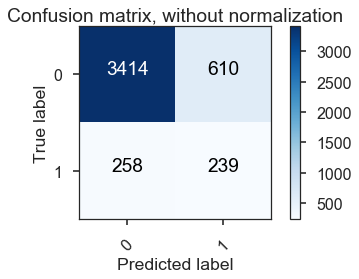

########################################################
             precision    recall  f1-score   support

          0       0.93      0.85      0.89      4024
          1       0.28      0.48      0.36       497

avg / total       0.86      0.81      0.83      4521

--- 22.706291437149048 seconds ---


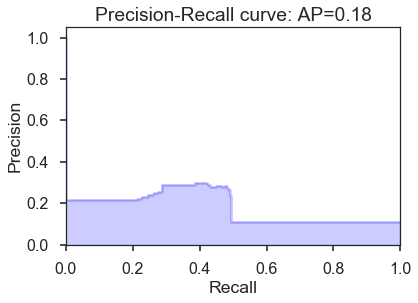

In [104]:
start_time = time.time()
clfdt = tree.DecisionTreeClassifier()

#GridSearch Parameters
parameters = {"max_depth": [ 4, 5, 6, 7,9,11,13,15,17,19,21], 'min_samples_leaf': [1, 2, 3, 4, 5, 6,7,8]}

# parameters={'max_depth': [7], 'min_samples_leaf': [1]}

clfdt_smote_50, Xtrain, ytrain, Xtest, ytest= do_classify(clfdt, parameters, X_train_smote_50, 
                                                          X_test, y_train_smote_50, y_test)

make_pr("clfdt",clfdt_smote_50, ytest, Xtest)

print(classification_report(y_test, clfdt_smote_50.predict(X_test) , target_names=['0','1']))

print("--- %s seconds ---" % (time.time() - start_time))

#### 1.5.3.2.6 Fitting DT on SMOTE dataset having a sampling ratio of 30:70 (Minority:Majority)

C:\Users\musta\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


BEST {'max_depth': 8, 'min_samples_leaf': 1} 0.801387091945 [mean: 0.74946, std: 0.00731, params: {'max_depth': 1, 'min_samples_leaf': 1}, mean: 0.74946, std: 0.00731, params: {'max_depth': 1, 'min_samples_leaf': 2}, mean: 0.74946, std: 0.00731, params: {'max_depth': 1, 'min_samples_leaf': 3}, mean: 0.74946, std: 0.00731, params: {'max_depth': 1, 'min_samples_leaf': 4}, mean: 0.74946, std: 0.00731, params: {'max_depth': 1, 'min_samples_leaf': 5}, mean: 0.74946, std: 0.00731, params: {'max_depth': 1, 'min_samples_leaf': 6}, mean: 0.74946, std: 0.00731, params: {'max_depth': 1, 'min_samples_leaf': 7}, mean: 0.74946, std: 0.00731, params: {'max_depth': 1, 'min_samples_leaf': 8}, mean: 0.74540, std: 0.01099, params: {'max_depth': 2, 'min_samples_leaf': 1}, mean: 0.74540, std: 0.01099, params: {'max_depth': 2, 'min_samples_leaf': 2}, mean: 0.74540, std: 0.01099, params: {'max_depth': 2, 'min_samples_leaf': 3}, mean: 0.74540, std: 0.01099, params: {'max_depth': 2, 'min_samples_leaf': 4}, mea

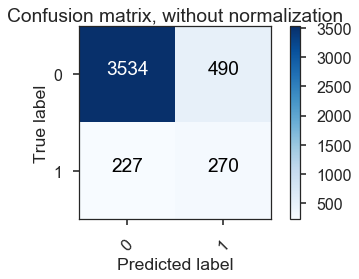

########################################################
             precision    recall  f1-score   support

          0       0.94      0.88      0.91      4024
          1       0.36      0.54      0.43       497

avg / total       0.88      0.84      0.86      4521

--- 11.834718227386475 seconds ---


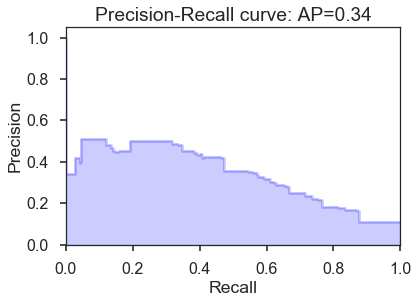

In [106]:
start_time = time.time()
clfdt = tree.DecisionTreeClassifier()

#GridSearch parameters
parameters = {"max_depth": [1, 2, 3, 4, 5, 6,7,8], 'min_samples_leaf': [1, 2, 3, 4, 5, 6,7,8]}

# parameters={'max_depth': [8], 'min_samples_leaf': [7]}

clfdt_smote_30, Xtrain, ytrain, Xtest, ytest= do_classify(clfdt, parameters, X_train_smote_30, 
                                                          X_test, y_train_smote_30, y_test)

make_pr("clfdt",clfdt_smote_30, ytest, Xtest)

print(classification_report(y_test, clfdt_smote_30.predict(X_test) , target_names=['0','1']))

print("--- %s seconds ---" % (time.time() - start_time))

### 1.5.3.3 Random Forest

In [46]:
from sklearn.ensemble import RandomForestClassifier

#### 1.5.3.3.1 Fitting RF on RUS dataset having a sampling ratio of 50:50 (Minority:Majority)

C:\Users\musta\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


BEST {'max_depth': 9, 'max_features': 'sqrt', 'n_estimators': 400} 0.753415909616 [mean: 0.74256, std: 0.01433, params: {'max_depth': 3, 'max_features': 'auto', 'n_estimators': 200}, mean: 0.74168, std: 0.01406, params: {'max_depth': 3, 'max_features': 'auto', 'n_estimators': 300}, mean: 0.74215, std: 0.00981, params: {'max_depth': 3, 'max_features': 'auto', 'n_estimators': 400}, mean: 0.74390, std: 0.01475, params: {'max_depth': 3, 'max_features': 'auto', 'n_estimators': 500}, mean: 0.74606, std: 0.01410, params: {'max_depth': 3, 'max_features': 'auto', 'n_estimators': 600}, mean: 0.74779, std: 0.01200, params: {'max_depth': 3, 'max_features': 'auto', 'n_estimators': 800}, mean: 0.73825, std: 0.00954, params: {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 200}, mean: 0.73946, std: 0.01188, params: {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 300}, mean: 0.74254, std: 0.01218, params: {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 400}, mean: 0.73947, st

############# based on standard predict ################
Accuracy on training data: 0.89
Accuracy on test data:     0.77
Confusion matrix, without normalization
[[3112  912]
 [ 142  355]]


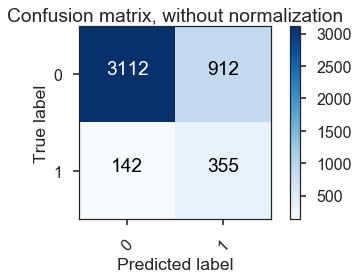

########################################################
             precision    recall  f1-score   support

          0       0.96      0.77      0.86      4024
          1       0.28      0.71      0.40       497

avg / total       0.88      0.77      0.81      4521

--- 285.43872690200806 seconds ---


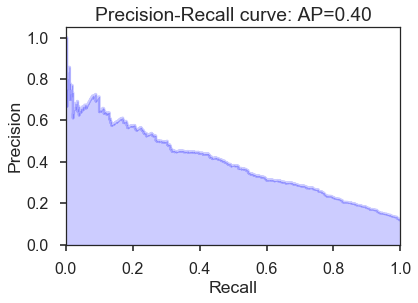

In [110]:
start_time = time.time()

clfForest = RandomForestClassifier(class_weight='balanced')

parameters = {"n_estimators": [200,300,400,500,600,800],"max_features":['auto','sqrt','log2'],
             "max_depth":[3,5,7,9,11]}

# parameters={'max_depth': [4], 'max_features': ['auto'], 'n_estimators': [220]}

clfForest_rus_50, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest, parameters,X_train_rus_50,
                                                             X_test, y_train_rus_50, y_test)

make_pr("clfForest",clfForest_rus_50, ytest, Xtest)
print(classification_report(y_test, clfForest_rus_50.predict(X_test) , target_names=['0','1']))

print("--- %s seconds ---" % (time.time() - start_time))

#### 2.5.3.3.2 Fitting RF on RUS dataset having a sampling ratio of 30:70 (Minority:Majority)

C:\Users\musta\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


BEST {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 600} 0.79419422617 [mean: 0.76817, std: 0.00943, params: {'max_depth': 2, 'max_features': 'auto', 'n_estimators': 200}, mean: 0.76724, std: 0.01282, params: {'max_depth': 2, 'max_features': 'auto', 'n_estimators': 300}, mean: 0.76858, std: 0.01412, params: {'max_depth': 2, 'max_features': 'auto', 'n_estimators': 400}, mean: 0.77007, std: 0.01404, params: {'max_depth': 2, 'max_features': 'auto', 'n_estimators': 500}, mean: 0.76596, std: 0.01383, params: {'max_depth': 2, 'max_features': 'auto', 'n_estimators': 600}, mean: 0.76942, std: 0.01251, params: {'max_depth': 2, 'max_features': 'auto', 'n_estimators': 800}, mean: 0.76879, std: 0.01340, params: {'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 200}, mean: 0.76914, std: 0.01349, params: {'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 300}, mean: 0.76884, std: 0.01165, params: {'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 400}, mean: 0.76858, st

############# based on standard predict ################
Accuracy on training data: 0.90
Accuracy on test data:     0.80
Confusion matrix, without normalization
[[3311  713]
 [ 173  324]]


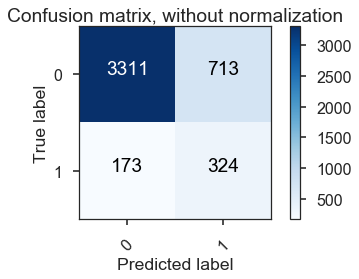

########################################################
             precision    recall  f1-score   support

          0       0.95      0.82      0.88      4024
          1       0.31      0.65      0.42       497

avg / total       0.88      0.80      0.83      4521

--- 600.6806161403656 seconds ---


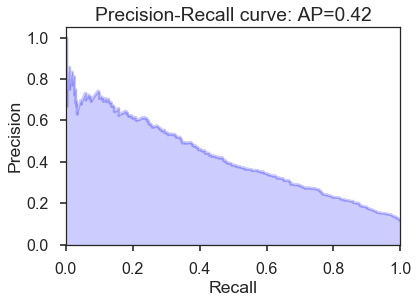

In [112]:
start_time = time.time()

clfForest = RandomForestClassifier(class_weight='balanced')

parameters = {"n_estimators": [200,300,400,500,600,800],"max_features":['auto','sqrt','log2'],
             "max_depth":[2,4,6,8,10,12,14]}

# parameters={'max_depth': [8], 'max_features': ['auto'], 'n_estimators': [300]}

clfForest_rus_30, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest, parameters,X_train_rus_30,
                                                             X_test, y_train_rus_30,ytest)

make_pr("clfForest",clfForest_rus_30, ytest, Xtest)
print(classification_report(y_test, clfForest_rus_30.predict(X_test) , target_names=['0','1']))

print("--- %s seconds ---" % (time.time() - start_time))

#### 1.5.3.3.3 Fitting RF on ROS dataset having a sampling ratio of 50:50 (Minority:Majority)

C:\Users\musta\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


BEST {'max_depth': 14, 'max_features': 'sqrt', 'n_estimators': 500} 0.936268247059 [mean: 0.74350, std: 0.00704, params: {'max_depth': 2, 'max_features': 'auto', 'n_estimators': 200}, mean: 0.74203, std: 0.00665, params: {'max_depth': 2, 'max_features': 'auto', 'n_estimators': 300}, mean: 0.74264, std: 0.00648, params: {'max_depth': 2, 'max_features': 'auto', 'n_estimators': 400}, mean: 0.74270, std: 0.00703, params: {'max_depth': 2, 'max_features': 'auto', 'n_estimators': 500}, mean: 0.74264, std: 0.00620, params: {'max_depth': 2, 'max_features': 'auto', 'n_estimators': 600}, mean: 0.74286, std: 0.00448, params: {'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 200}, mean: 0.74156, std: 0.00642, params: {'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 300}, mean: 0.74395, std: 0.00607, params: {'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 400}, mean: 0.74409, std: 0.00518, params: {'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 500}, mean: 0.74258, s

############# based on standard predict ################
Accuracy on training data: 0.97
Accuracy on test data:     0.85
Confusion matrix, without normalization
[[3584  440]
 [ 252  245]]


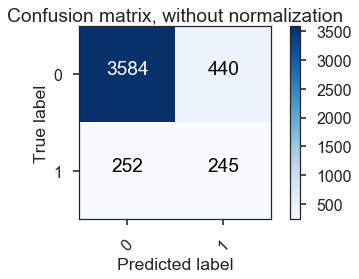

########################################################
             precision    recall  f1-score   support

          0       0.93      0.89      0.91      4024
          1       0.36      0.49      0.41       497

avg / total       0.87      0.85      0.86      4521

--- 1698.9343914985657 seconds ---


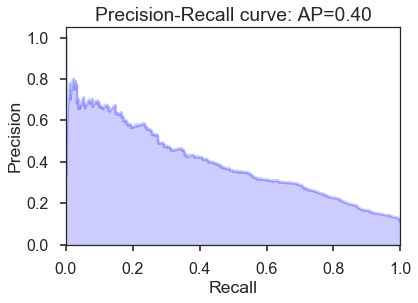

In [113]:
start_time = time.time()

clfForest = RandomForestClassifier(class_weight='balanced')

#GridSearch parameters
parameters = {"n_estimators": [200,300,400,500,600],"max_features":['auto','sqrt','log2'],
             "max_depth":[2,4,6,8,10,12,14]}

# parameters={'max_depth': [10], 'max_features': ['log2'], 'n_estimators': [200]}

clfForest_ros_50, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest, parameters,X_train_ros_50,
                                                             X_test, y_train_ros_50, y_test)

make_pr("clfForest",clfForest_ros_50, ytest, Xtest)
print(classification_report(y_test, clfForest_ros_50.predict(X_test) , target_names=['0','1']))

print("--- %s seconds ---" % (time.time() - start_time))

#### 1.5.3.3.4 Fitting RF on ROS dataset having a sampling ratio of 30:70 (Minority:Majority)

C:\Users\musta\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


BEST {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 300} 0.859344133738 [mean: 0.76114, std: 0.00537, params: {'max_depth': 2, 'max_features': 'auto', 'n_estimators': 200}, mean: 0.76206, std: 0.00501, params: {'max_depth': 2, 'max_features': 'auto', 'n_estimators': 300}, mean: 0.75936, std: 0.00357, params: {'max_depth': 2, 'max_features': 'auto', 'n_estimators': 400}, mean: 0.76172, std: 0.00454, params: {'max_depth': 2, 'max_features': 'auto', 'n_estimators': 500}, mean: 0.76089, std: 0.00438, params: {'max_depth': 2, 'max_features': 'auto', 'n_estimators': 600}, mean: 0.76088, std: 0.00349, params: {'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 200}, mean: 0.76053, std: 0.00410, params: {'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 300}, mean: 0.76129, std: 0.00420, params: {'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 400}, mean: 0.76037, std: 0.00356, params: {'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 500}, mean: 0.76009, s

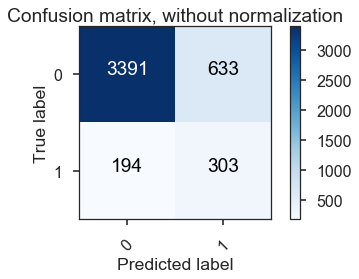

########################################################
             precision    recall  f1-score   support

          0       0.95      0.84      0.89      4024
          1       0.32      0.61      0.42       497

avg / total       0.88      0.82      0.84      4521

--- 811.0834128856659 seconds ---


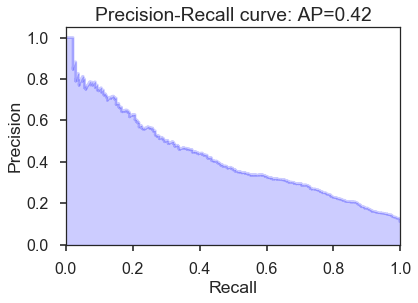

In [115]:
from sklearn.ensemble import RandomForestClassifier
start_time = time.time()

clfForest = RandomForestClassifier(class_weight='balanced')

#GridSearch paramters
parameters = {"n_estimators": [200,300,400,500,600],"max_features":['auto','sqrt','log2'],
            "max_depth":[2,4,6,8,10]}

# parameters={'max_depth': [12], 'max_features': ['sqrt'], 'n_estimators': [600]}

clfForest_ros_30, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest, parameters,X_train_ros_30,
                                                             X_test, y_train_ros_30, y_test)

make_pr("clfForest",clfForest_ros_30, ytest, Xtest)
print(classification_report(y_test, clfForest_ros_30.predict(X_test) , target_names=['0','1']))

print("--- %s seconds ---" % (time.time() - start_time))

#### 1.5.3.3.5 Fitting RF on SMOTE dataset having a sampling ratio of 50:50 (Minority:Majority)

C:\Users\musta\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


BEST {'max_depth': 10, 'max_features': 'auto', 'n_estimators': 400} 0.839090144186 [mean: 0.74125, std: 0.00773, params: {'max_depth': 2, 'max_features': 'auto', 'n_estimators': 200}, mean: 0.74032, std: 0.00732, params: {'max_depth': 2, 'max_features': 'auto', 'n_estimators': 300}, mean: 0.74418, std: 0.00548, params: {'max_depth': 2, 'max_features': 'auto', 'n_estimators': 400}, mean: 0.74147, std: 0.00756, params: {'max_depth': 2, 'max_features': 'auto', 'n_estimators': 500}, mean: 0.74283, std: 0.00683, params: {'max_depth': 2, 'max_features': 'auto', 'n_estimators': 600}, mean: 0.74286, std: 0.00689, params: {'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 200}, mean: 0.74179, std: 0.00739, params: {'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 300}, mean: 0.74172, std: 0.00557, params: {'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 400}, mean: 0.74200, std: 0.00706, params: {'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 500}, mean: 0.74195, s

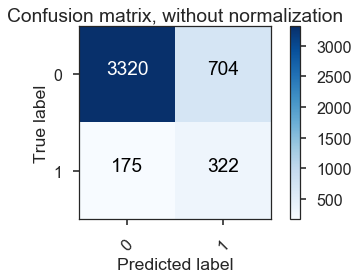

########################################################
             precision    recall  f1-score   support

          0       0.95      0.83      0.88      4024
          1       0.31      0.65      0.42       497

avg / total       0.88      0.81      0.83      4521

--- 1252.0813212394714 seconds ---


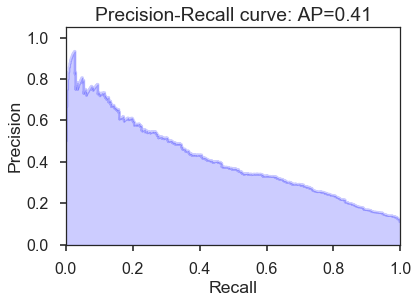

In [116]:
start_time = time.time()

clfForest = RandomForestClassifier(class_weight='balanced')

#GridSearch Parameters
parameters = {"n_estimators": [200,300,400,500,600],"max_features":['auto','sqrt','log2'],
            "max_depth":[2,4,6,8,10]}

# parameters = {"n_estimators": [30],"max_features":['auto'], "max_depth":[7], "min_samples_leaf":[7],
#              "min_samples_split":[5]}

clfForest_smote_50, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest, parameters,
                                                               X_train_smote_50, X_test, 
                                                               y_train_smote_50, y_test)

make_pr("clfForest",clfForest_smote_50, ytest, Xtest)

print(classification_report(y_test, clfForest_smote_50.predict(X_test) , target_names=['0','1']))

print("--- %s seconds ---" % (time.time() - start_time))

#### 1.5.3.3.6 Fitting RF on SMOTE dataset having a sampling ratio of 30:70 (Minority:Majority)

C:\Users\musta\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


BEST {'max_depth': 20, 'max_features': 'log2', 'n_estimators': 500} 0.874089534298 [mean: 0.85930, std: 0.00445, params: {'max_depth': 14, 'max_features': 'auto', 'n_estimators': 200}, mean: 0.85858, std: 0.00503, params: {'max_depth': 14, 'max_features': 'auto', 'n_estimators': 300}, mean: 0.85955, std: 0.00498, params: {'max_depth': 14, 'max_features': 'auto', 'n_estimators': 400}, mean: 0.85861, std: 0.00560, params: {'max_depth': 14, 'max_features': 'auto', 'n_estimators': 500}, mean: 0.86053, std: 0.00567, params: {'max_depth': 14, 'max_features': 'auto', 'n_estimators': 600}, mean: 0.86004, std: 0.00473, params: {'max_depth': 14, 'max_features': 'auto', 'n_estimators': 800}, mean: 0.86196, std: 0.00617, params: {'max_depth': 14, 'max_features': 'sqrt', 'n_estimators': 200}, mean: 0.85912, std: 0.00416, params: {'max_depth': 14, 'max_features': 'sqrt', 'n_estimators': 300}, mean: 0.85977, std: 0.00449, params: {'max_depth': 14, 'max_features': 'sqrt', 'n_estimators': 400}, mean: 0

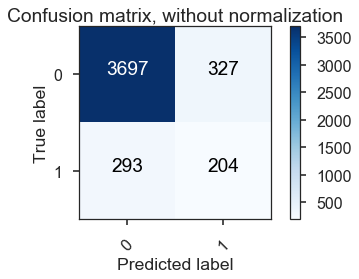

########################################################
             precision    recall  f1-score   support

          0       0.93      0.92      0.92      4024
          1       0.38      0.41      0.40       497

avg / total       0.87      0.86      0.86      4521

--- 1535.1936385631561 seconds ---


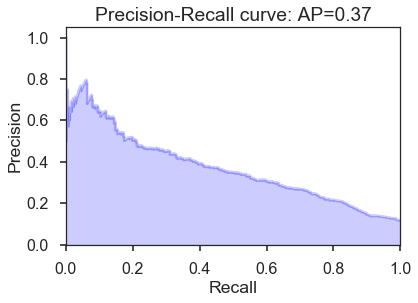

In [117]:
start_time = time.time()

clfForest = RandomForestClassifier(class_weight='balanced')

#Gridsearch
parameters = {"n_estimators": [200,300,400,500,600,800],"max_features":['auto','sqrt','log2'],
             "max_depth":[14,16,18,20]}

# parameters = {'n_estimators':[800],'max_features':['sqrt'],'max_depth':[16]}       

clfForest_smote_30, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest, parameters,
                                                               X_train_smote_30, X_test, 
                                                               y_train_smote_30, y_test)

make_pr("clfForest",clfForest_smote_30, ytest, Xtest)
print(classification_report(y_test, clfForest_smote_30.predict(X_test) , target_names=['0','1']))

print("--- %s seconds ---" % (time.time() - start_time))

## 1.6 Results

![Result_table](images/result_table.PNG)

For each classifier, test F-1 score and Average Precision is shown in the table.

The best classifier came out to be **Random Forest with a sampling setting of RUS with sampling ratio 50/50**.

This neither overfits or underfits the data. This can be seen by seeing the ability of the model to be generalizable. Here, to check overfitting we see the difference between the F1 of train and F1 of test. If the difference is very high then the model is overfitting. Here, we can see that there is a very small difference between AUC train (0.85) and AUC test(0.83). Thus, it tells us that the model is not overfitting.

Also, we observe that Logistic Regression Classifier's results do not change with sampling setting and sampling ratio. All of 6 combinations have similar and consistent results. Thus, overall logistic regression also performs well in this setting.

Decision tree classifier tends to fit only the majority class (0) and not the minority. All of the majority class' precision, recall and f1 score are high but all of these metrics of minority class are low.

Also, while choosing the classifier I chose the one which had the highest recall and precision for the minority class along with F1 score and Average Precision.

## Given more data I would have..

One of the most successful ways of tackling the class imbalance problem is through **cost sensitive training**. This tactic penalizes learning algorithms that increase the cost of classification mistakes on the minority class.

In this method a cost function is created which acts as a scoring function (instead of F1 or AUC) on which the hyperparameters of the algorithms are optimized. Bearing False Positives and False Negatives has an associated cost. The alogrithm which gives us the lowest cost is chosen.

For example, if we are solving a predictive maintenance problem for windmills where false positive will mean that we predicted a good mill as bad and false negative means we predicted a bad mill as good. Here, we would want to minimize false negatives which  will lead to two types of cost:
a) Mill downtime cost and b)expediting new parts(if any) order cost whereas a false positive cost will be comprosed of inventory cost of new parts. This will be our cost function which the algorithm will minimize.

**Steps**:

1) Choose RUS sampling technique and form a mix of sampling ratios (50:50, 60:40, 70:30 ...)

2) Fit a learning algorithm on each of the sampling ratio formed and calculate the associated cost.

3) Choose the best sampling ratio having minimum cost.

4) Build several copies of this model (best sampling ratio + learning algorithm) by selecting a different seed for every time you are sampling and average them using ensemble modelling.